In [1]:
"""
Judge Statistics Analysis Module

This Jupyter notebook provides comprehensive statistical analysis and visualization
of RAG (Retrieval-Augmented Generation) evaluation metrics. It processes evaluation
data from multiple judge models and chat models, computing descriptive statistics,
performing ANOVA tests, and generating various visualizations including heatmaps,
distribution plots, and response duration analysis.

Key Features:
- Load and preprocess evaluation data from JSON files
- Compute descriptive statistics (mean, std) for different model groupings
- Perform ANOVA analysis to test for significant differences
- Generate comprehensive visualizations (box plots, bar charts, violin plots, heatmaps)
- Analyze model response durations with statistical insights
- Rank models based on performance metrics
- Conduct effect size analysis using Cohen's d
- Perform Tukey HSD post-hoc tests for pairwise comparisons
- Create correlation matrices and variance analysis
- Provide statistical validation and consistency checks

Dependencies:
- pandas: Data manipulation and analysis
- matplotlib: Basic plotting functionality
- seaborn: Statistical data visualization
- numpy: Numerical computations
- scipy: Statistical tests
- plotly: Interactive visualizations
- IPython: Display utilities
- statsmodels: Advanced statistical analysis (Tukey HSD)

Data Structure:
The notebook expects evaluation data in JSON format with the following structure:
- judge_model: Name of the judging model
- timestamp: Evaluation timestamp
- models_results: List of results for each chat model
  - model: Chat model name
  - question: Evaluation question
  - metrics: List of metric scores
    - metric: Metric name (e.g., "AnswerRelevancy")
    - score: Numerical score (0-1 range)

Analysis Components:
1. Comprehensive Metric Analysis:
   - Box plots showing score distributions by chat/judge model
   - Bar charts with error bars for mean scores
   - Violin plots for density distributions
   - Summary statistics tables with mean, std, min, max, count

2. Heatmap Analysis:
   - Mean score heatmaps by model type
   - Standard deviation heatmaps showing variability
   - Model correlation matrices for consistency analysis
   - Variance analysis across metrics

3. Duration Analysis:
   - Response time distributions by model
   - Average duration comparisons with statistical insights
   - Performance timing analysis

4. Statistical Testing:
   - ANOVA tests for group differences
   - Tukey HSD for pairwise comparisons
   - Effect size analysis (Cohen's d) with interpretation
   - Model ranking and performance validation

5. Advanced Analytics:
   - Grand mean validation for data consistency
   - Effect size interpretation (small/medium/large effects)
   - Statistical significance testing with p-values
   - Comprehensive insights and recommendations

Output:
- Statistical summaries and ANOVA results
- Comprehensive visualization suites for each analysis type
- Model rankings in markdown format with performance metrics
- Duration analysis with performance insights and recommendations
- Effect size interpretations and statistical significance tests
- Validation reports for data consistency and reliability

Usage:
1. Ensure evaluation data exists in ../data/evaluation_by_judge.json
2. Run cells sequentially for complete analysis
3. Review statistical outputs and visualizations
4. Use insights for model selection and evaluation methodology improvements

Note: This notebook is designed to work from the notebooks/ directory and automatically
handles path resolution for data files in the ../data/ directory.

Author: Jukka Veijanen
"""

import json
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from IPython.display import display
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import sys
import os

# Add parent directory to path for Jupyter notebook
sys.path.append(os.path.abspath(".."))

from src.eval import load_and_merge_data, EvaluationConfig
from src.config import get, get_logger, setup_logging
from pathlib import Path

# Initialize configuration
config = EvaluationConfig()

print(f'results_csv: {config.results_csv}')
print(f'ground_truth_csv: {config.ground_truth_csv}')
print(f'output_file: {config.output_file}')

# Override configuration paths for Jupyter Notebook context
# Using pathlib.Path for proper path resolution relative to notebook location
notebook_dir = Path.cwd()  # Current working directory (notebooks/)
config.results_csv = str(notebook_dir.parent / config.results_csv)
config.ground_truth_csv = str(notebook_dir.parent / config.ground_truth_csv)
config.output_file = str(notebook_dir.parent / config.output_file)

# Setup logging (uses configs/logging_config.yml)
logger = setup_logging()

# Access config values
app_name = get("app.name")
judge_model = get("models.judge.default")

logger.info(f"Application: {app_name}")
logger.info(f"Default judge model: {judge_model}")

# Configuration
metrics_to_evaluate = [
    "AnswerRelevancy",  # Measures how relevant the answer is to the question
    "ContextPrecision",  # Measures precision of retrieved context
    "ContextRecall",  # Measures recall of retrieved context
    "Faithfulness",  # Measures faithfulness of answer to context
]
default_figsize = (15, 6)  # Standard figure size for plots

/home/jukka/repo/chat_eval/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-03 23:27:29,774 - src.config - INFO - Basic logging configuration applied
2025-11-03 23:27:29,775 - src.config - INFO - Application: LLM Evaluation Framework
2025-11-03 23:27:29,775 - src.config - INFO - Default judge model: codellama:latest


✓ Configuration loaded from /home/jukka/repo/chat_eval/configs/settings.yml
results_csv: data/results.csv
ground_truth_csv: data/ground_truth.csv
output_file: outputs/evaluation_by_judge.json
⚠ Error setting up logging: Unable to configure handler 'error_file'
✓ Configuration loaded from /home/jukka/repo/chat_eval/configs/settings.yml


In [2]:
def set_centered_xticks(ax, labels, rotation=0):
    """
    Sets x-axis ticks with centered labels and no rotation.

    This utility function standardizes x-axis formatting across all plots
    by centering labels under bars and removing rotation for better readability.

    Args:
        ax (matplotlib.axes.Axes): The matplotlib axis object to modify
        labels (list or array): List of labels for x-axis ticks

    Returns:
        None: Modifies the axis object in-place

    Example:
        >>> fig, ax = plt.subplots()
        >>> ax.bar(['A', 'B', 'C'], [1, 2, 3])
        >>> set_centered_xticks(ax, ['Model A', 'Model B', 'Model C'])
    """
    group_centers = np.arange(len(labels))
    ax.set_xticks(group_centers)
    ax.set_xticklabels(labels, rotation=rotation, ha="center")


def add_values_to_bars(ax, rotation=60):
    """
    Adds value labels on top of bars in matplotlib bar charts.

    Enhances bar charts by displaying the exact numerical values on top of each bar,
    making it easier to read precise values without relying solely on the y-axis scale.

    Args:
        ax (matplotlib.axes.Axes): The matplotlib axis object containing bar chart

    Returns:
        None: Modifies the axis object in-place by adding text labels

    Note:
        - Values are formatted to 3 decimal places
        - Labels are rotated 60 degrees to prevent overlap
        - Font size is set to 8 for readability

    Example:
        >>> ax = df.plot(kind='bar')
        >>> add_values_to_bars(ax)
    """
    for container in ax.containers:
        ax.bar_label(container, fmt="%.3f", rotation=rotation, fontsize=8)

In [3]:
def parse_metadata(df):
    """
    Parses JSON metadata strings from DataFrame into Python dictionaries.

    Converts metadata column containing JSON-like strings into proper Python
    dictionaries. Handles common formatting issues like single quotes and
    boolean values that need conversion for JSON compliance.

    Args:
        df (pd.DataFrame): DataFrame with 'metadata' column containing JSON strings

    Returns:
        list: List of parsed dictionaries, one for each row in the DataFrame

    Raises:
        json.JSONDecodeError: If JSON parsing fails after preprocessing

    Note:
        - Converts single quotes to double quotes for JSON compliance
        - Converts Python boolean values (True/False) to JSON format (true/false)
        - Handles escaped quotes properly

    Example:
        >>> df = pd.DataFrame({'metadata': ["{'model': 'gpt-4', 'duration': 1000}"]})
        >>> parsed = parse_metadata(df)
        >>> print(parsed[0]['model'])  # 'gpt-4'
    """
    json_metadata = []
    for idx, row in df.iterrows():
        orig_metadata_str = row["metadata"]
        # Convert single quotes to double quotes for JSON compliance
        metadata_str = re.sub(r"(?<!\\)'", '"', orig_metadata_str)
        # Convert Python booleans to JSON format
        metadata_str = re.sub(r"\bTrue\b", "true", metadata_str, flags=re.IGNORECASE)
        metadata_str = re.sub(r"\bFalse\b", "false", metadata_str, flags=re.IGNORECASE)
        parsed = json.loads(metadata_str)
        json_metadata.append(parsed)
    return json_metadata


def extract_durations_by_model(data):
    """
    Extracts all durations for each model from the metadata.

    Args:
        data (list): List of dictionaries containing model metadata
                    Each dict should have 'model' and 'total_duration' keys

    Returns:
        dict: Dictionary mapping model names to lists of durations in nanoseconds
              Format: {model_name: [duration1, duration2, ...]}

    Example:
        >>> data = [{'model': 'gpt-4', 'total_duration': 2000000000},
        ...         {'model': 'gpt-4', 'total_duration': 3000000000}]
        >>> durations = extract_durations_by_model(data)
        >>> print(durations['gpt-4'])  # [2000000000, 3000000000]
    """
    durations_by_model = {}

    for item in data:
        model = item["model"]
        duration = item["total_duration"]
        durations_by_model.setdefault(model, []).append(duration)

    return durations_by_model


def calculate_average_duration(data):
    """
    Calculates the average total_duration for each model from the extracted data.

    This function first extracts all durations per model, then calculates
    the average duration for each model, converting from nanoseconds to seconds.

    Args:
        data (list): List of dictionaries containing model metadata
                    Each dict should have 'model' and 'total_duration' keys

    Returns:
        tuple: (averages_dict, durations_dict) where:
            - averages_dict: Dictionary mapping model names to average durations in seconds
            - durations_dict: Dictionary mapping model names to lists of all durations

    Example:
        >>> data = [{'model': 'gpt-4', 'total_duration': 2000000000}]
        >>> averages, durations = calculate_average_duration(data)
        >>> print(averages['gpt-4'])  # 2.0 (seconds)
        >>> print(durations['gpt-4'])  # [2000000000] (nanoseconds)
    """
    if not data:
        print("No data to process.")
        return {}, {}

    # Extract all durations by model
    durations_by_model = extract_durations_by_model(data)

    # Calculate averages and convert nanoseconds to seconds
    averages = {}
    for model, durations in durations_by_model.items():
        avg_duration_ns = sum(durations) / len(durations)
        averages[model] = avg_duration_ns / 1_000_000_000  # Convert to seconds

    return averages, durations_by_model

In [4]:
def load_and_preprocess_data(file_path):
    """
    Loads and preprocesses evaluation data from JSON file.

    Reads JSON evaluation data, normalizes the nested structure into a flat
    DataFrame, handles missing values, and prepares data for analysis.

    Args:
        file_path (str): Path to JSON file containing evaluation results

    Returns:
        pd.DataFrame: Preprocessed DataFrame with columns:
                     ['judge_model', 'timestamp', 'chat_model', 'question', 'metric', 'score']

    Data Processing Steps:
        1. Load JSON data from file
        2. Flatten nested structure (judge -> models -> metrics)
        3. Handle NaN values in scores (drops rows with NaN scores)
        4. Rename 'model' column to 'chat_model' for clarity

    Example:
        >>> df = load_and_preprocess_data('evaluation_results.json')
        >>> print(df.columns)
        Index(['judge_model', 'timestamp', 'chat_model', 'question', 'metric', 'score'])
    """
    with open(file_path, "r") as file:
        data = json.load(file)

    rows = []
    for entry in data:
        judge = entry["judge_model"]
        timestamp = entry["timestamp"]
        for result in entry["results"]:
            # for result in entry["models_results"]:
            model = result["model"]
            question = result["question"]
            for metric in result["metrics"]:
                rows.append(
                    {
                        "judge_model": judge,
                        "timestamp": timestamp,
                        "chat_model": model,
                        "question": question,
                        "metric": metric["metric"],
                        "score": metric["score"],
                    }
                )

    df = pd.DataFrame(rows)

    # Handle NaN values: Check for NaN and drop rows with NaN in 'score'
    nan_count = df["score"].isna().sum()
    print(f"NaN values in 'score' before handling: {nan_count}")
    if nan_count > 0:
        print(
            "Impact of NaN: They are ignored in mean/std calculations, reducing sample size and potentially biasing results if non-random."
        )
    df = df.dropna(subset=["score"])

    print("DataFrame shape after handling NaN:", df.shape)
    return df


def compute_descriptive_stats(df, group_col, metrics):
    """
    Computes descriptive statistics for each metric by group.

    Calculates mean and standard deviation for each metric, grouped by the
    specified column (e.g., judge_model or chat_model).

    Args:
        df (pd.DataFrame): DataFrame containing evaluation data
        group_col (str): Column name to group by (e.g., 'judge_model', 'chat_model')
        metrics (list): List of metric names to analyze

    Returns:
        dict: Dictionary mapping metric names to DataFrames with statistics
              Format: {metric_name: DataFrame with 'mean' and 'std' columns}

    Example:
        >>> stats = compute_descriptive_stats(df, 'judge_model', ['AnswerRelevancy'])
        >>> print(stats['AnswerRelevancy']['mean'])  # Series of mean scores by judge
    """
    stats_dict = {}
    for metric in metrics:
        metric_df = df[df["metric"] == metric]
        stats_dict[metric] = metric_df.groupby(group_col)["score"].agg(["mean", "std"])
    return stats_dict

In [5]:
def perform_anova(df, group_col, metrics):
    """
    Performs one-way ANOVA tests for each metric.

    Tests whether there are statistically significant differences in mean scores
    between groups (e.g., different judge models or chat models) for each metric.

    Args:
        df (pd.DataFrame): DataFrame containing evaluation data
        group_col (str): Column name defining groups for comparison
        metrics (list): List of metric names to test

    Returns:
        pd.DataFrame: DataFrame with columns ['metric', 'F-value', 'p-value']
                     containing ANOVA results for each metric

    Statistical Interpretation:
        - F-value: Ratio of between-group to within-group variance
        - p-value: Probability of observing results if null hypothesis is true
        - p < 0.05 typically indicates significant differences between groups

    Example:
        >>> anova_results = perform_anova(df, 'judge_model', metrics)
        >>> significant = anova_results[anova_results['p-value'] < 0.05]
    """
    anova_results = []
    for metric in metrics:
        metric_df = df[df["metric"] == metric]
        groups = [group["score"].values for name, group in metric_df.groupby(group_col)]
        f_stat, p_value = stats.f_oneway(*groups)
        anova_results.append({"metric": metric, "F-value": f_stat, "p-value": p_value})
    return pd.DataFrame(anova_results)


def display_anova_results(anova_df, title):
    """
    Displays ANOVA results in a formatted table.

    Presents ANOVA test results in a clean, readable format with proper
    headers and formatting for easy interpretation.

    Args:
        anova_df (pd.DataFrame): DataFrame containing ANOVA results
        title (str): Title to display above the results table

    Returns:
        None: Displays results using IPython.display

    Example:
        >>> anova_df = perform_anova(df, 'judge_model', metrics)
        >>> display_anova_results(anova_df, "ANOVA Results for Judge Models")
    """
    print(f"\n{title}")
    print("=" * len(title))
    display(anova_df)

In [6]:
def rank_models(df, metrics):
    """
    Ranks chat models based on overall and per-metric performance.

    Computes overall rankings based on mean scores across all metrics,
    as well as detailed rankings for each individual metric.

    Args:
        df (pd.DataFrame): DataFrame containing evaluation data
        metrics (list): List of metric names to include in ranking

    Returns:
        tuple: (overall_rankings, detailed_rankings)
            - overall_rankings (pd.DataFrame): Overall model rankings with columns
              ['chat_model', 'mean_score', 'rank']
            - detailed_rankings (dict): Per-metric rankings
              Format: {metric_name: DataFrame with model rankings for that metric}

    Ranking Method:
        - Overall: Average of mean scores across all specified metrics
        - Per-metric: Individual metric performance
        - Ties are handled using minimum ranking method

    Example:
        >>> overall, detailed = rank_models(df, metrics)
        >>> print(overall.head())  # Top-ranked models
        >>> print(detailed['AnswerRelevancy'])  # Rankings for specific metric
    """
    # Compute mean scores per model across all metrics
    model_means = df.groupby("chat_model")["score"].mean().reset_index()
    model_means.columns = ["chat_model", "mean_score"]

    # Sort by mean score in descending order to get ranking
    model_means = model_means.sort_values(by="mean_score", ascending=False)
    model_means["rank"] = model_means["mean_score"].rank(ascending=False, method="min")

    # Compute mean scores per metric per model for detailed ranking
    detailed_ranks = {}
    for metric in metrics:
        metric_df = (
            df[df["metric"] == metric]
            .groupby("chat_model")["score"]
            .mean()
            .reset_index()
        )
        metric_df = metric_df.sort_values(by="score", ascending=False)
        metric_df["rank_" + metric] = metric_df["score"].rank(
            ascending=False, method="min"
        )
        detailed_ranks[metric] = metric_df

    return model_means, detailed_ranks


def generate_ranking_markdown(model_means, detailed_ranks, metrics):
    """
    Generates markdown-formatted ranking report.

    Creates a comprehensive markdown report showing overall model rankings
    and detailed per-metric rankings in table format.

    Args:
        model_means (pd.DataFrame): Overall model rankings
        detailed_ranks (dict): Per-metric ranking DataFrames
        metrics (list): List of metric names

    Returns:
        str: Markdown-formatted string containing complete ranking report

    Report Structure:
        1. Overall Rankings Table - Models ranked by average performance
        2. Per-Metric Rankings - Individual tables for each metric

    Example:
        >>> overall, detailed = rank_models(df, metrics)
        >>> markdown = generate_ranking_markdown(overall, detailed, metrics)
        >>> display(Markdown(markdown))  # Render in Jupyter
    """
    markdown_text = """
# Model Rankings Based on RAGAs Evaluation Metrics

## Overall Ranking
The models are ranked based on their average mean scores across all metrics. The ranking is as follows:

| Rank | Model            | Mean Score         |
|------|------------------|---------------------|
"""
    for index, row in model_means.iterrows():
        markdown_text += (
            f"| {int(row['rank'])} | {row['chat_model']} | {row['mean_score']:.4f} |\n"
        )

    markdown_text += """
## Per-Metric Rankings
Detailed rankings for each metric are provided below, showing how models perform individually:

"""
    for metric in metrics:
        markdown_text += f"### {metric}\n"
        markdown_text += "| Rank | Model            | Mean Score         |\n"
        markdown_text += "|------|------------------|---------------------|\n"
        for index, row in detailed_ranks[metric].iterrows():
            markdown_text += f"| {int(row['rank_' + metric])} | {row['chat_model']} | {row['score']:.4f} |\n"
        markdown_text += "\n"

    return markdown_text

In [7]:
def apply_axis_styling(ax, title, ylabel, xlabel, grid=True, rotation=0):
    """
    Applies common styling to matplotlib axis objects.

    Args:
        ax (matplotlib.axes.Axes): Axis object to style
        title (str): Plot title
        ylabel (str): Y-axis label
        xlabel (str): X-axis label
        grid (bool, optional): Whether to show grid. Defaults to True
        rotation (int, optional): X-axis label rotation. Defaults to 45
    """
    ax.set_title(title, fontsize=12, fontweight="bold")
    ax.set_ylabel(ylabel)
    ax.set_xlabel("")  # Remove x-axis label
    if grid:
        ax.grid(True, axis="y", linestyle="--", alpha=0.7)
    ax.tick_params(axis="x", rotation=rotation)


def apply_color_styling(plot_elements, colors, alpha=0.7):
    """
    Applies color styling to plot elements.

    Args:
        plot_elements (list): List of plot elements to color
        colors (array): Color array for styling
        alpha (float, optional): Transparency level. Defaults to 0.7
    """
    for element, color in zip(plot_elements, colors):
        element.set_facecolor(color)
        element.set_alpha(alpha)


def style_table_cells(table, num_rows, num_cols):
    """
    Applies styling to table cells.

    Args:
        table: Matplotlib table object
        num_rows (int): Number of rows including header
        num_cols (int): Number of columns
    """
    for i in range(num_rows):
        for j in range(num_cols):
            cell = table[(i, j)]
            if i == 0:  # Header row
                cell.set_facecolor("#4CAF50")
                cell.set_text_props(weight="bold", color="white")
            else:
                cell.set_facecolor("#f0f0f0" if i % 2 == 0 else "white")

In [8]:
def create_boxplot(ax, values, labels, colors, title, ylabel, xlabel):
    """
    Creates a generic box plot.

    Args:
        ax (matplotlib.axes.Axes): Axis object for plotting
        values (list): List of value arrays for each category
        labels (list): List of category names
        colors (array): Color array for styling
        title (str): Plot title
        ylabel (str): Y-axis label
        xlabel (str): X-axis label
    """
    bp = ax.boxplot(values, tick_labels=labels, patch_artist=True)
    apply_axis_styling(ax, title, ylabel, xlabel)
    apply_color_styling(bp["boxes"], colors)


def create_barplot_with_error(
    ax, labels, values, errors, colors, title, ylabel, xlabel, value_format=".2f"
):
    """
    Creates a generic bar chart with error bars and value labels.

    Args:
        ax (matplotlib.axes.Axes): Axis object for plotting
        labels (list): List of category names
        values (list): List of mean values
        errors (list): List of error values (std dev)
        colors (array): Color array for styling
        title (str): Plot title
        ylabel (str): Y-axis label
        xlabel (str): X-axis label
        value_format (str): Format string for value labels
    """
    bars = ax.bar(
        labels,
        values,
        yerr=errors,
        capsize=5,
        color=colors,
        alpha=0.7,
        edgecolor="black",
        linewidth=1,
    )
    apply_axis_styling(ax, title, ylabel, xlabel)

    # Add value labels on bars
    for bar, val, err in zip(bars, values, errors):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + err + 0.01,
            f"{val:{value_format}}",
            ha="center",
            va="bottom",
            fontsize=9,
        )


def create_violinplot(ax, values, labels, colors, title, ylabel, xlabel, rotation=0):
    """
    Creates a generic violin plot.

    Args:
        ax (matplotlib.axes.Axes): Axis object for plotting
        values (list): List of value arrays for each category
        labels (list): List of category names
        colors (array): Color array for styling
        title (str): Plot title
        ylabel (str): Y-axis label
        xlabel (str): X-axis label
    """
    vp = ax.violinplot(
        values,
        positions=range(1, len(labels) + 1),
        showmeans=True,
        showmedians=True,
    )
    apply_axis_styling(ax, title, ylabel, xlabel)

    ax.set_xticks(range(1, len(labels) + 1))
    ax.set_xticklabels(labels, rotation=rotation)
    apply_color_styling(vp["bodies"], colors)


def create_summary_table(ax, labels, data_dict, columns, title, value_format=".3f"):
    """
    Creates a generic summary statistics table.

    Args:
        ax (matplotlib.axes.Axes): Axis object for the table
        labels (list): List of category names
        data_dict (dict): Dictionary mapping labels to data arrays
        columns (list): List of column names for statistics
        title (str): Table title
        value_format (str): Format string for numeric values
    """
    ax.axis("tight")
    ax.axis("off")

    # Calculate summary statistics
    summary_data = []
    for label in labels:
        data = data_dict[label]
        row = [label]
        if "mean" in columns:
            row.append(f"{np.mean(data):{value_format}}")
        if "median" in columns:
            row.append(f"{np.median(data):{value_format}}")
        if "std" in columns:
            row.append(f"{np.std(data):{value_format}}")
        if "min" in columns:
            row.append(f"{np.min(data):{value_format}}")
        if "max" in columns:
            row.append(f"{np.max(data):{value_format}}")
        if "count" in columns:
            row.append(f"{len(data)}")
        summary_data.append(row)

    # Create table
    col_labels = ["Category"] + [col.capitalize() for col in columns]
    table = ax.table(
        cellText=summary_data,
        colLabels=col_labels,
        cellLoc="center",
        loc="center",
    )
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    ax.set_title(title, fontsize=12, fontweight="bold", pad=20)

    # Style the table
    style_table_cells(table, len(labels) + 1, len(col_labels))


def print_analysis_insights(data_dict, labels, data_type="values"):
    """
    Prints comprehensive insights about the analysis.

    Args:
        data_dict (dict): Dictionary mapping labels to data arrays
        labels (list): List of category names
        data_type (str): Type of data being analyzed (for display)
    """
    print(f"\n{'='*60}")
    print(f"{data_type.upper()} ANALYSIS INSIGHTS")
    print(f"{'='*60}")

    # Calculate means for comparison
    means = {label: np.mean(data_dict[label]) for label in labels}

    # Find best and worst performing
    best_label = max(means.keys(), key=lambda k: means[k])
    worst_label = min(means.keys(), key=lambda k: means[k])

    print(f"Best performing: {best_label} ({means[best_label]:.3f} average)")
    print(f"Worst performing: {worst_label} ({means[worst_label]:.3f} average)")

    if means[best_label] != means[worst_label]:
        performance_ratio = means[best_label] / means[worst_label]
        print(f"Performance difference: {performance_ratio:.2f}x (best vs worst)")

    # Calculate total data points
    total_points = sum(len(data) for data in data_dict.values())
    print(f"Total data points analyzed: {total_points}")

    # Show variability insights
    cv_dict = {
        label: np.std(data_dict[label]) / np.mean(data_dict[label])
        for label in labels
        if np.mean(data_dict[label]) != 0
    }

    if cv_dict:
        most_consistent = min(cv_dict.keys(), key=lambda k: cv_dict[k])
        most_variable = max(cv_dict.keys(), key=lambda k: cv_dict[k])

        print(f"Most consistent: {most_consistent}")
        print(f"Most variable: {most_variable}")


def visualize_metric_analysis(df, metric_name, group_col="chat_model", figsize=default_figsize):
    """
    Creates comprehensive visualizations for metric analysis by model.

    Args:
        df (pd.DataFrame): DataFrame containing evaluation data
        metric_name (str): Name of the metric to analyze
        group_col (str): Column to group by (default: "chat_model")
        figsize (tuple): Figure size for the plots
    """
    # Filter data for the specific metric
    metric_df = df[df["metric"] == metric_name]

    if metric_df.empty:
        print(f"No data available for metric: {metric_name}")
        return

    # Prepare data
    grouped_data = metric_df.groupby(group_col)["score"]
    labels = list(grouped_data.groups.keys())
    values = [grouped_data.get_group(label).values for label in labels]
    means = [np.mean(vals) for vals in values]
    stds = [np.std(vals) for vals in values]
    colors = plt.cm.Set3(np.linspace(0, 1, len(labels)))

    # Create data dictionary for insights
    data_dict = {label: vals for label, vals in zip(labels, values)}

    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=figsize)

    # Create plots
    create_boxplot(
        ax1,
        values,
        labels,
        colors,
        f"{metric_name} Score Distribution by {group_col.replace('_', ' ').title()}",
        "Score",
        group_col.replace("_", " ").title(),
    )

    create_barplot_with_error(
        ax2,
        labels,
        means,
        stds,
        colors,
        f"Average {metric_name} Score by {group_col.replace('_', ' ').title()}",
        "Average Score",
        group_col.replace("_", " ").title(),
    )

    create_violinplot(
        ax3,
        values,
        labels,
        colors,
        f"{metric_name} Score Density Distribution by {group_col.replace('_', ' ').title()}",
        "Score",
        group_col.replace("_", " ").title(),
    )

    create_summary_table(
        ax4,
        labels,
        data_dict,
        ["mean", "median", "std", "min", "max", "count"],
        f"{metric_name} Summary Statistics",
    )

    plt.tight_layout()
    plt.show()

    # Print insights
    print_analysis_insights(data_dict, labels, f"{metric_name} scores")


# Refactored duration analysis using generic functions
def visualize_duration_analysis(durations_by_model, averages, figsize=default_figsize):
    """
    Creates comprehensive visualizations for model response duration analysis.
    """
    if not durations_by_model:
        print("No duration data available for visualization.")
        return

    # Convert nanoseconds to seconds
    durations_seconds = {
        model: [d / 1_000_000_000 for d in durations]
        for model, durations in durations_by_model.items()
    }

    # Prepare data
    models = list(durations_seconds.keys())
    duration_values = list(durations_seconds.values())
    means = [averages[model] for model in models]
    stds = [np.std(durations_seconds[model]) for model in models]
    colors = plt.cm.Set3(np.linspace(0, 1, len(models)))

    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=figsize)

    # Create plots using generic functions
    create_boxplot(
        ax1,
        duration_values,
        models,
        colors,
        "Response Duration Distribution by Model",
        "Duration (seconds)",
        "",
    )

    create_barplot_with_error(
        ax2,
        models,
        means,
        stds,
        colors,
        "Average Response Duration by Model",
        "Average Duration (seconds)",
        "",
        ".2f",
    )

    create_violinplot(
        ax3,
        duration_values,
        models,
        colors,
        "Duration Density Distribution by Model",
        "Duration (seconds)",
        "",
    )

    create_summary_table(
        ax4,
        models,
        durations_seconds,
        ["mean", "median", "std", "min", "max", "count"],
        "Duration Summary Statistics",
        ".2f",
    )

    plt.tight_layout()
    plt.show()

    # Print insights
    print_analysis_insights(durations_seconds, models, "duration")

In [9]:
# Load evaluation data
print(f"\nLoading evaluation data from {config.output_file}...")

evaluation_data = load_and_preprocess_data(config.output_file)
evaluation_data = evaluation_data[evaluation_data["metric"].isin(metrics_to_evaluate)]
print(f"Loaded {len(evaluation_data)} evaluation records")

# Load and parse metadata for duration analysis
print("\nLoading and parsing metadata...")
merged_df = load_and_merge_data(config)
metadata_list = parse_metadata(merged_df)
print(f"Parsed metadata for {len(metadata_list)} entries")

2025-11-03 23:27:29,841 - config - INFO - Basic logging configuration applied
2025-11-03 23:27:29,841 - src.eval - INFO - Loading data files:
2025-11-03 23:27:29,842 - src.eval - INFO -   Results: /home/jukka/repo/chat_eval/data/results.csv
2025-11-03 23:27:29,842 - src.eval - INFO -   Ground Truth: /home/jukka/repo/chat_eval/data/ground_truth.csv
2025-11-03 23:27:29,843 - src.eval - INFO - Loaded 12 rows from results file
2025-11-03 23:27:29,845 - src.eval - INFO - Loaded 4 rows from ground truth file
2025-11-03 23:27:29,846 - src.eval - INFO - Successfully merged data: 12 rows



Loading evaluation data from /home/jukka/repo/chat_eval/outputs/evaluation_by_judge.json...
NaN values in 'score' before handling: 0
DataFrame shape after handling NaN: (43, 6)
Loaded 43 evaluation records

Loading and parsing metadata...
⚠ Error setting up logging: Unable to configure handler 'error_file'
Parsed metadata for 12 entries



METRIC ANALYSIS BY CHAT MODEL

Analyzing metric: AnswerRelevancy


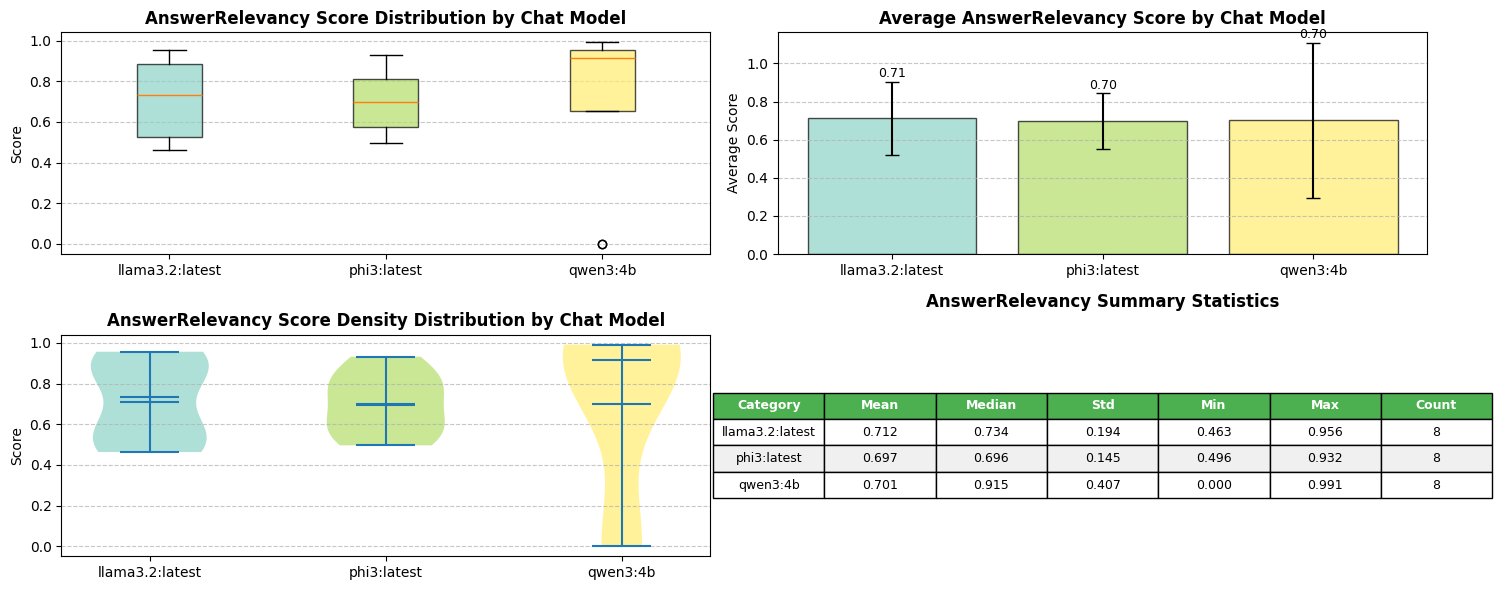


ANSWERRELEVANCY SCORES ANALYSIS INSIGHTS
Best performing: llama3.2:latest (0.712 average)
Worst performing: phi3:latest (0.697 average)
Performance difference: 1.02x (best vs worst)
Total data points analyzed: 24
Most consistent: phi3:latest
Most variable: qwen3:4b

Analyzing metric: Faithfulness


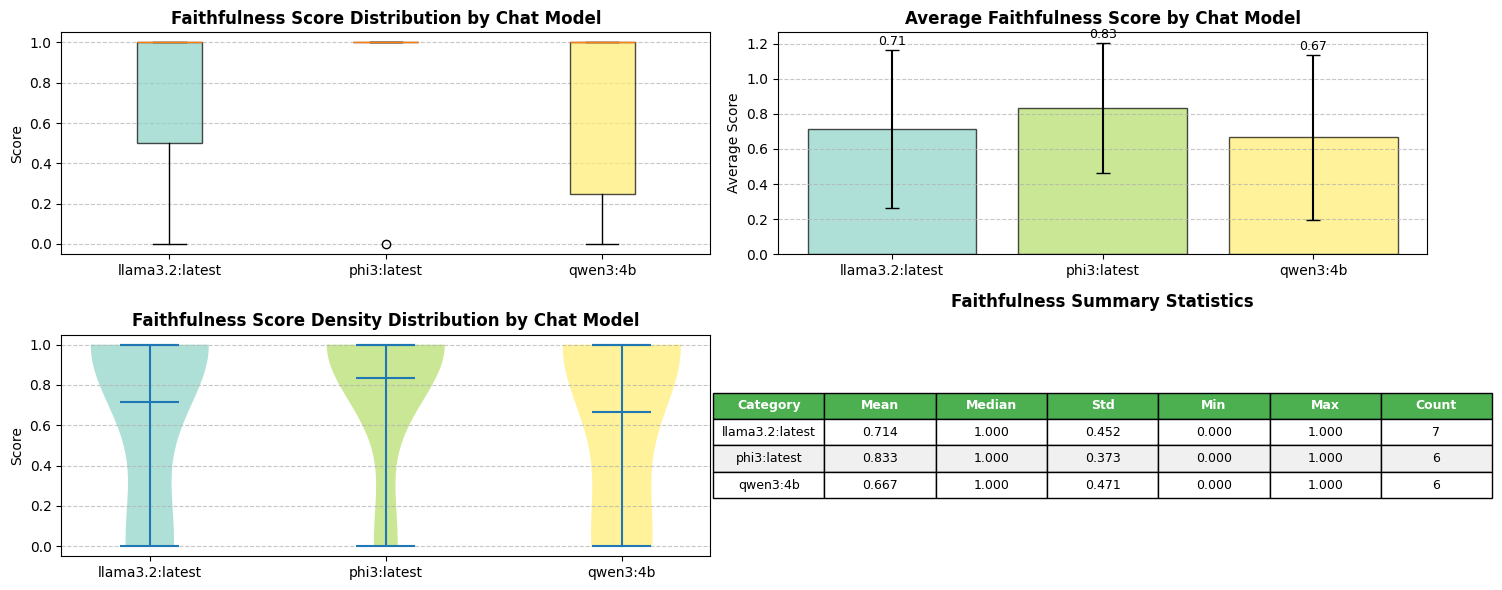


FAITHFULNESS SCORES ANALYSIS INSIGHTS
Best performing: phi3:latest (0.833 average)
Worst performing: qwen3:4b (0.667 average)
Performance difference: 1.25x (best vs worst)
Total data points analyzed: 19
Most consistent: phi3:latest
Most variable: qwen3:4b

METRIC ANALYSIS BY JUDGE MODEL

Analyzing metric: AnswerRelevancy


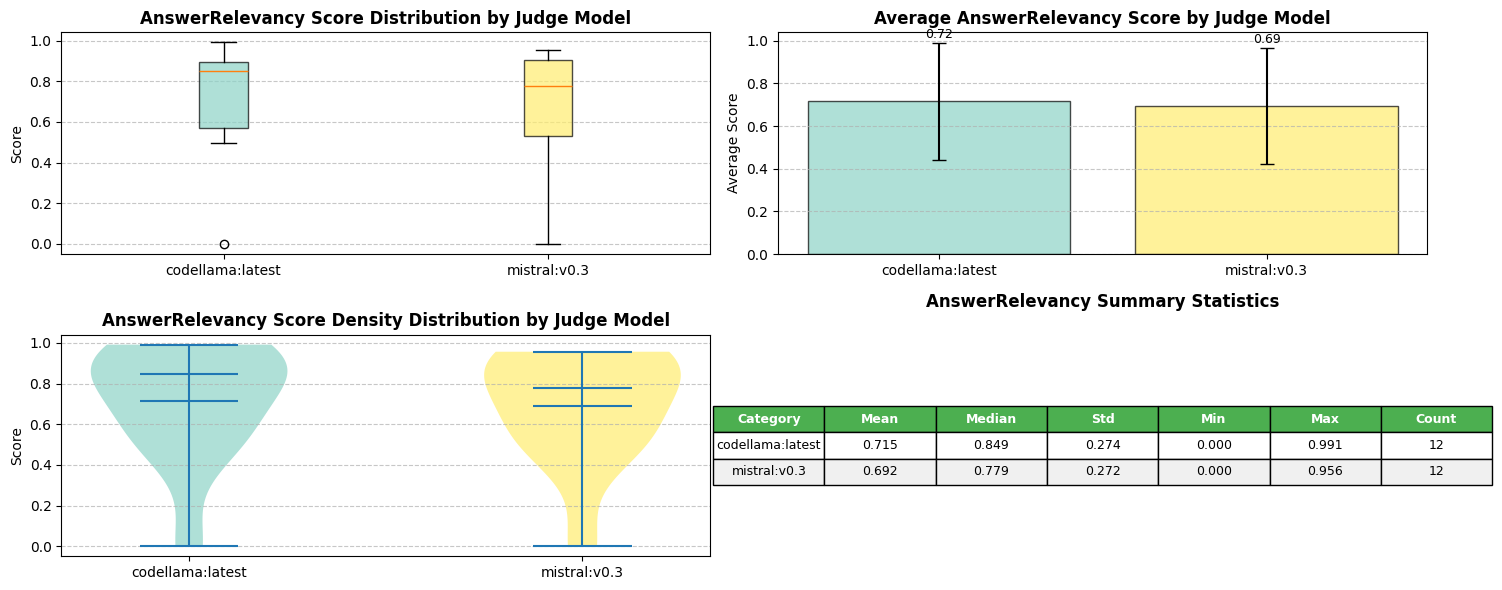


ANSWERRELEVANCY SCORES ANALYSIS INSIGHTS
Best performing: codellama:latest (0.715 average)
Worst performing: mistral:v0.3 (0.692 average)
Performance difference: 1.03x (best vs worst)
Total data points analyzed: 24
Most consistent: codellama:latest
Most variable: mistral:v0.3

Analyzing metric: Faithfulness


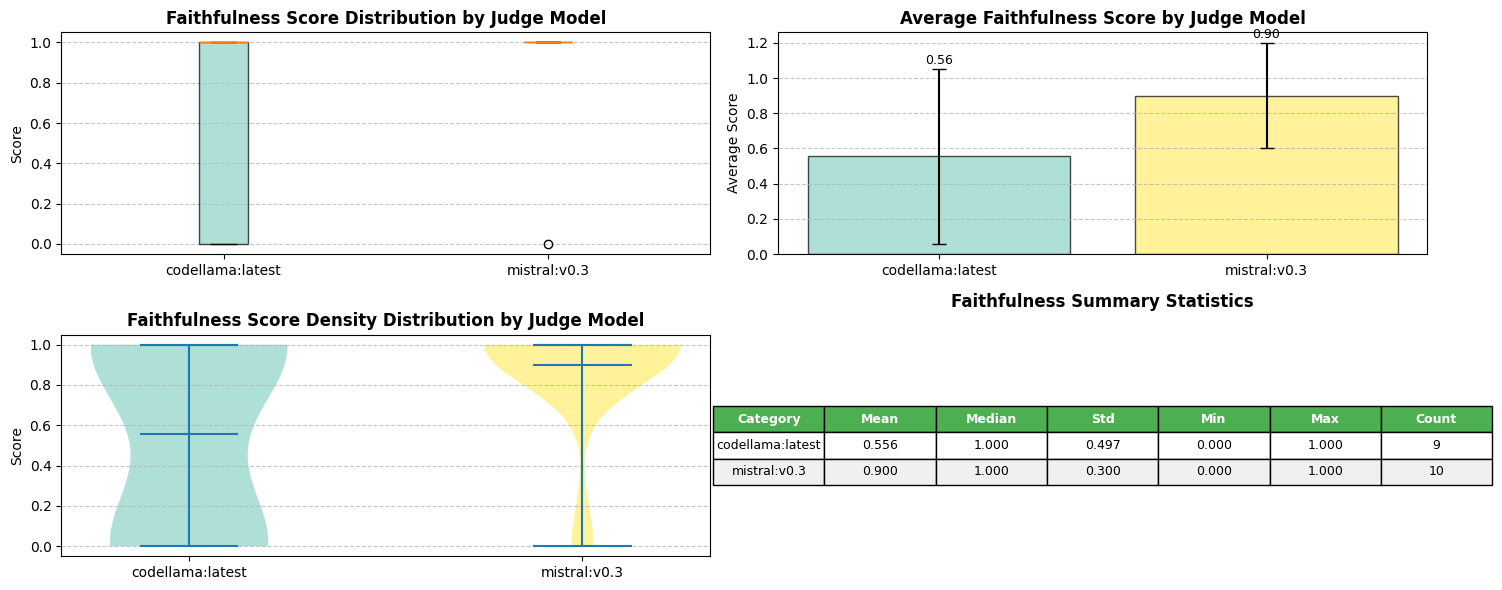


FAITHFULNESS SCORES ANALYSIS INSIGHTS
Best performing: mistral:v0.3 (0.900 average)
Worst performing: codellama:latest (0.556 average)
Performance difference: 1.62x (best vs worst)
Total data points analyzed: 19
Most consistent: mistral:v0.3
Most variable: codellama:latest

RESPONSE DURATION ANALYSIS


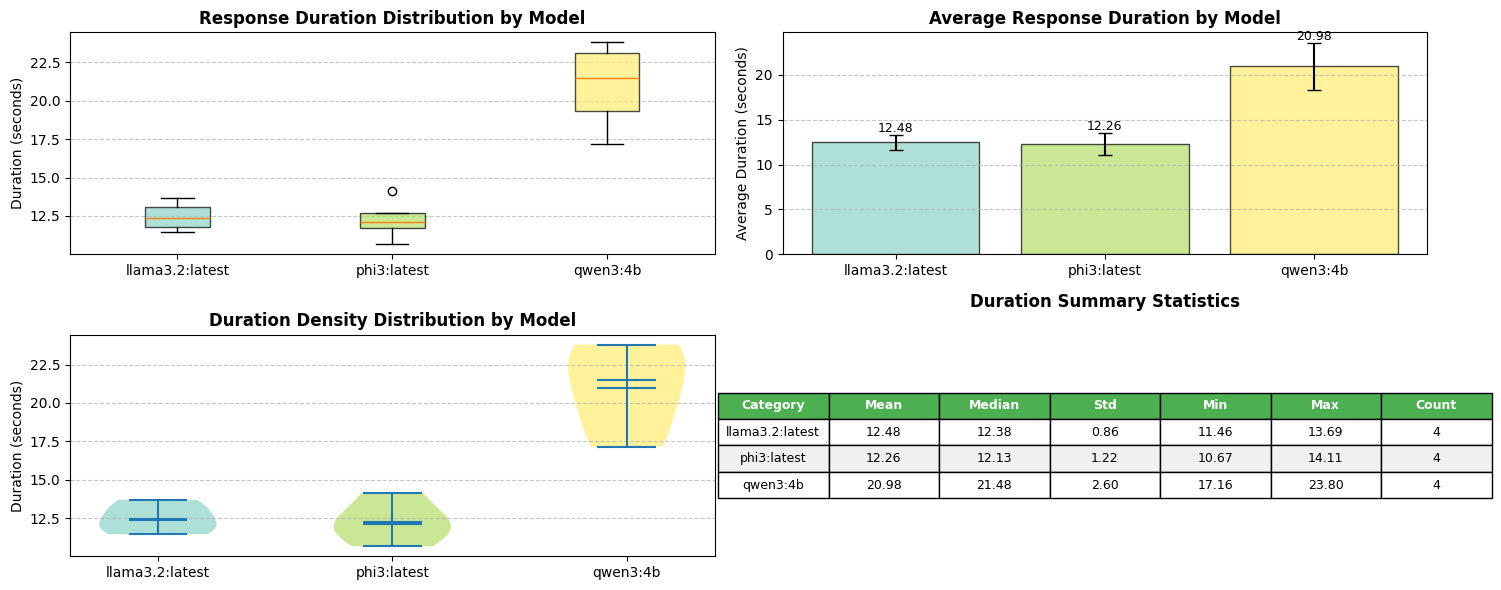


DURATION ANALYSIS INSIGHTS
Best performing: qwen3:4b (20.978 average)
Worst performing: phi3:latest (12.263 average)
Performance difference: 1.71x (best vs worst)
Total data points analyzed: 12
Most consistent: llama3.2:latest
Most variable: qwen3:4b


In [10]:
# Usage example for metric analysis
if not evaluation_data.empty:
    print("\n" + "=" * 70)
    print("METRIC ANALYSIS BY CHAT MODEL")
    print("=" * 70)
    
    # Analyze each metric separately
    unique_metrics = evaluation_data["metric"].unique()
    for metric in unique_metrics:
        print(f"\nAnalyzing metric: {metric}")
        visualize_metric_analysis(evaluation_data, metric, group_col="chat_model")
    
    print("\n" + "=" * 70)
    print("METRIC ANALYSIS BY JUDGE MODEL")
    print("=" * 70)
    
    # Analyze metrics by judge model
    for metric in unique_metrics:
        print(f"\nAnalyzing metric: {metric}")
        visualize_metric_analysis(evaluation_data, metric, group_col="judge_model")
else:
    print("\n⚠️  Skipping metric analysis - evaluation data not loaded")
    print("Please ensure evaluation_by_judge.json exists and run the previous cell again.")

# Duration analysis call
if len(metadata_list) > 0:
    print("\n" + "=" * 70)
    print("RESPONSE DURATION ANALYSIS")
    print("=" * 70)
    
    # Extract durations and calculate averages
    durations_by_model = extract_durations_by_model(metadata_list)
    averages, _ = calculate_average_duration(metadata_list)
    
    # Create comprehensive duration visualizations
    visualize_duration_analysis(durations_by_model, averages)
else:
    print("\n⚠️  Skipping duration analysis - metadata not loaded")
    print("Please ensure results.csv and ground_truth.csv exist and run the previous cell again.")

In [11]:
# =============================================================================
# ADVANCED STATISTICAL ANALYSIS WITH HEATMAPS
# =============================================================================

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Configuration for rounding precision
round_by = 6

def calculate_aggregated_stats(df, group_col, stats_to_compute=["mean", "std"]):
    """
    Calculates aggregated statistics using pandas .agg() method.

    More efficient approach to computing multiple statistics simultaneously
    using pandas built-in aggregation functions.

    Args:
        df (pd.DataFrame): DataFrame containing evaluation data
        group_col (str): Column prefix for grouping (e.g., 'judge', 'chat')
        stats_to_compute (list): List of statistics to calculate

    Returns:
        pd.DataFrame: MultiIndex DataFrame with statistics as columns
                     and (model, metric) as index

    Example:
        >>> stats = calculate_aggregated_stats(df, 'judge', ['mean', 'std', 'count'])
        >>> print(stats['mean'])  # Mean scores by judge model and metric
    """
    stats = (
        df.groupby([f"{group_col}_model", "metric"])["score"]
        .agg(stats_to_compute)
        .round(round_by)
    )
    return stats


def print_full_stats_tables(model_stats, model_group):
    """
    Prints comprehensive statistics tables.

    Displays complete statistical summaries in a formatted table for
    detailed numerical analysis.

    Args:
        model_stats (pd.DataFrame): Statistics DataFrame
        model_group (str): Model group name for header

    Returns:
        None: Prints formatted output
    """
    print("\n" + "-" * 70)
    print(f"FULL STATISTICS BY {model_group.upper()} MODEL")
    print("-" * 70)
    print(model_stats)


COMPREHENSIVE HEATMAP ANALYSIS - JUDGE MODELS


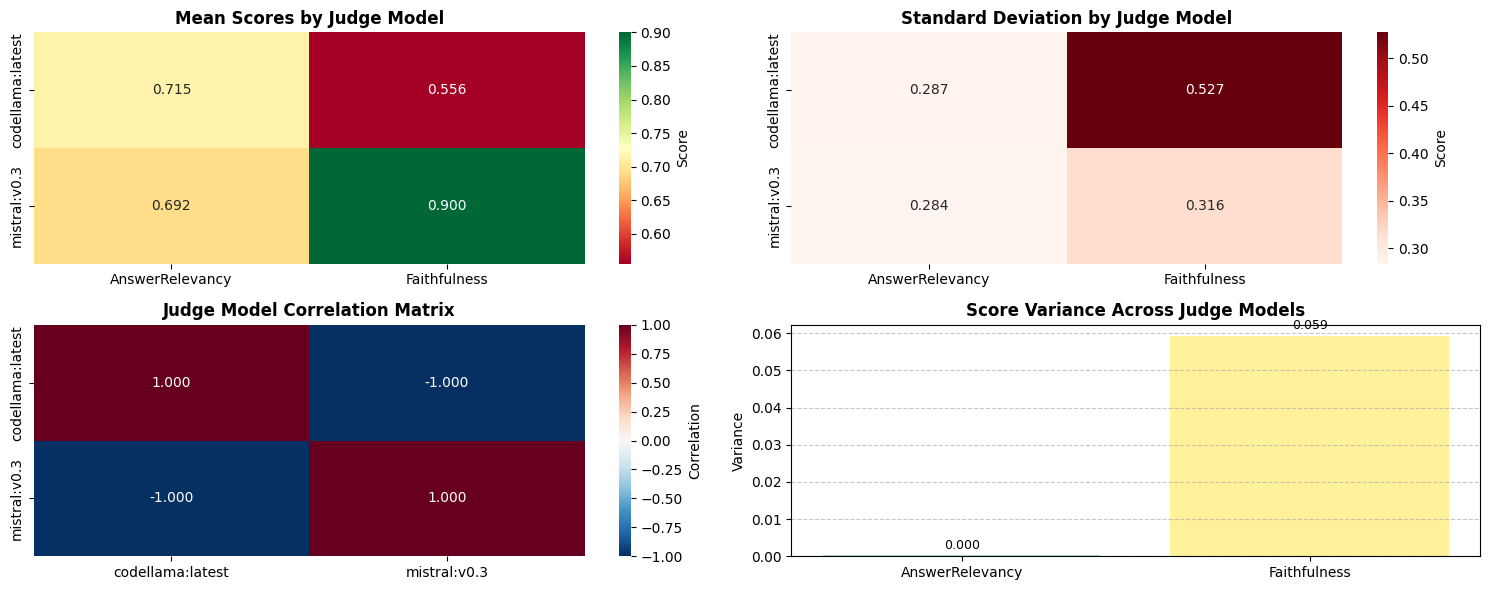


JUDGE MODEL HEATMAP ANALYSIS INSIGHTS
Best overall judge model: mistral:v0.3 (0.796)
Worst overall judge model: codellama:latest (0.635)
Most consistent judge model: mistral:v0.3 (std: 0.300)
Least consistent judge model: codellama:latest (std: 0.407)
Easiest metric: Faithfulness (0.728 avg)
Hardest metric: AnswerRelevancy (0.703 avg)

COMPREHENSIVE HEATMAP ANALYSIS - CHAT MODELS


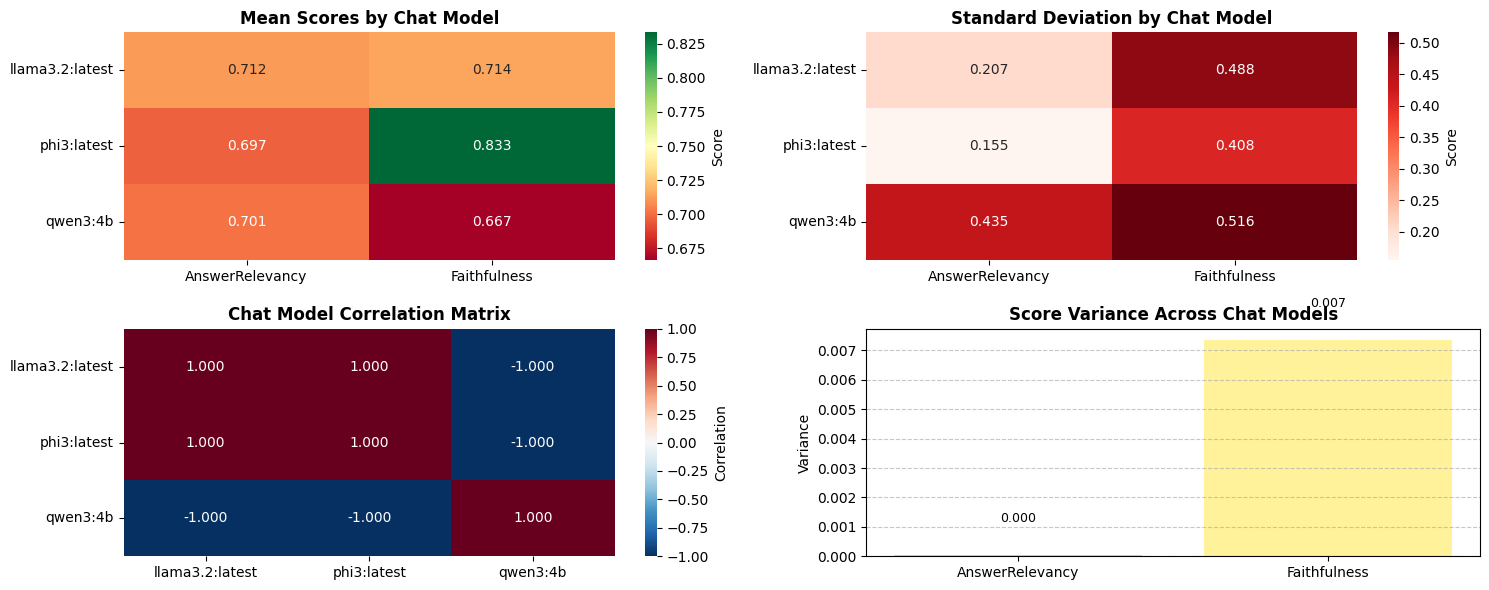


CHAT MODEL HEATMAP ANALYSIS INSIGHTS
Best overall chat model: phi3:latest (0.765)
Worst overall chat model: qwen3:4b (0.684)
Most consistent chat model: phi3:latest (std: 0.282)
Least consistent chat model: qwen3:4b (std: 0.476)
Easiest metric: Faithfulness (0.738 avg)
Hardest metric: AnswerRelevancy (0.703 avg)

VALIDATION: Grand Mean Comparison
Verifying consistency between judge and chat model aggregations...

----------------------------------------------------------------------
FULL STATISTICS BY JUDGE MODEL
----------------------------------------------------------------------
                                      mean       std
judge_model      metric                             
codellama:latest AnswerRelevancy  0.715036  0.286635
                 Faithfulness     0.555556  0.527046
mistral:v0.3     AnswerRelevancy  0.691792  0.283709
                 Faithfulness     0.900000  0.316228

----------------------------------------------------------------------
FULL STATISTICS BY 

In [12]:
def create_heatmap(ax, pivot_data, title, cmap="YlOrRd", annot=True, fmt=".3f", rotation=45):
    """
    Creates a standardized heatmap visualization.

    Args:
        ax (matplotlib.axes.Axes): Axis object for plotting
        pivot_data (pd.DataFrame): Pivoted data with models as index, metrics as columns
        title (str): Plot title
        cmap (str): Colormap name
        annot (bool): Whether to annotate cells with values
        fmt (str): Format string for annotations
    """
    sns.heatmap(
        pivot_data, annot=annot, fmt=fmt, cmap=cmap, ax=ax, cbar_kws={"label": "Score"}
    )
    apply_axis_styling(ax, title, "", "", grid=False, rotation=rotation)


def create_correlation_heatmap(ax, corr_matrix, title, rotation=45):
    """
    Creates a correlation heatmap with diverging colormap.

    Args:
        ax (matplotlib.axes.Axes): Axis object for plotting
        corr_matrix (pd.DataFrame): Correlation matrix
        title (str): Plot title
    """
    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt=".3f",
        cmap="RdBu_r",
        center=0,
        ax=ax,
        cbar_kws={"label": "Correlation"},
    )
    apply_axis_styling(ax, title, "", "", grid=False, rotation=rotation)


def create_variance_barplot(ax, variance_data, title, ylabel="Variance", rotation=45):
    """
    Creates a bar plot showing variance across metrics.

    Args:
        ax (matplotlib.axes.Axes): Axis object for plotting
        variance_data (pd.Series): Variance data by metric
        title (str): Plot title
        ylabel (str): Y-axis label
    """
    colors = plt.cm.Set3(np.linspace(0, 1, len(variance_data)))
    bars = ax.bar(variance_data.index, variance_data.values, color=colors, alpha=0.7)
    apply_axis_styling(ax, title, ylabel, "Metrics", rotation=rotation)

    # Add value labels
    for bar, val in zip(bars, variance_data.values):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.001,
            f"{val:.3f}",
            ha="center",
            va="bottom",
            fontsize=9,
        )


def visualize_heatmap_analysis(df, model_type="judge", figsize=default_figsize):
    """
    Creates comprehensive heatmap analysis for a specific model type.

    Args:
        df (pd.DataFrame): DataFrame containing evaluation data
        model_type (str): Type of model to analyze ("judge" or "chat")
        figsize (tuple): Figure size for the plots
    """
    # Calculate aggregated statistics
    stats = calculate_aggregated_stats(df, model_type)

    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize)

    # Plot 1: Mean scores heatmap
    mean_pivot = stats["mean"].unstack()
    create_heatmap(
        axes[0, 0],
        mean_pivot,
        f"Mean Scores by {model_type.title()} Model",
        cmap="RdYlGn",
        rotation=0,
    )

    # Plot 2: Standard deviation heatmap
    std_pivot = stats["std"].unstack()
    create_heatmap(
        axes[0, 1],
        std_pivot,
        f"Standard Deviation by {model_type.title()} Model",
        cmap="Reds",
        rotation=0,
    )

    # Plot 3: Model correlation matrix
    model_corr = mean_pivot.T.corr()
    create_correlation_heatmap(
        axes[1, 0], model_corr, f"{model_type.title()} Model Correlation Matrix", rotation=0,
    )

    # Plot 4: Variance across metrics
    metric_variance = mean_pivot.var(axis=0)
    create_variance_barplot(
        axes[1, 1],
        metric_variance,
        f"Score Variance Across {model_type.title()} Models",
        rotation=0,
    )

    plt.tight_layout()
    plt.show()

    # Print statistical insights
    print_heatmap_insights(stats, model_type, mean_pivot, std_pivot)


def print_heatmap_insights(stats, model_type, mean_pivot, std_pivot):
    """
    Prints statistical insights from heatmap analysis.

    Args:
        stats (pd.DataFrame): Aggregated statistics
        model_type (str): Type of model analyzed
        mean_pivot (pd.DataFrame): Pivoted mean scores
        std_pivot (pd.DataFrame): Pivoted standard deviations
    """
    print(f"\n{'='*60}")
    print(f"{model_type.upper()} MODEL HEATMAP ANALYSIS INSIGHTS")
    print(f"{'='*60}")

    # Best and worst performing models overall
    overall_means = mean_pivot.mean(axis=1)
    best_model = overall_means.idxmax()
    worst_model = overall_means.idxmin()

    print(
        f"Best overall {model_type} model: {best_model} ({overall_means[best_model]:.3f})"
    )
    print(
        f"Worst overall {model_type} model: {worst_model} ({overall_means[worst_model]:.3f})"
    )

    # Most and least consistent models
    overall_stds = std_pivot.mean(axis=1)
    most_consistent = overall_stds.idxmin()
    least_consistent = overall_stds.idxmax()

    print(
        f"Most consistent {model_type} model: {most_consistent} (std: {overall_stds[most_consistent]:.3f})"
    )
    print(
        f"Least consistent {model_type} model: {least_consistent} (std: {overall_stds[least_consistent]:.3f})"
    )

    # Metric-specific insights
    metric_means = mean_pivot.mean(axis=0)
    easiest_metric = metric_means.idxmax()
    hardest_metric = metric_means.idxmin()

    print(f"Easiest metric: {easiest_metric} ({metric_means[easiest_metric]:.3f} avg)")
    print(f"Hardest metric: {hardest_metric} ({metric_means[hardest_metric]:.3f} avg)")


# Refactored main execution - only run if data is loaded
if not evaluation_data.empty:
    judge_stats = calculate_aggregated_stats(evaluation_data, "judge")
    chat_stats = calculate_aggregated_stats(evaluation_data, "chat")
    
    print("\n" + "=" * 70)
    print("COMPREHENSIVE HEATMAP ANALYSIS - JUDGE MODELS")
    print("=" * 70)
    
    visualize_heatmap_analysis(evaluation_data, "judge")
    
    print("\n" + "=" * 70)
    print("COMPREHENSIVE HEATMAP ANALYSIS - CHAT MODELS")
    print("=" * 70)
    
    visualize_heatmap_analysis(evaluation_data, "chat")
    
    # Validation section remains the same
    print("\n" + "=" * 70)
    print("VALIDATION: Grand Mean Comparison")
    print("=" * 70)
    print("Verifying consistency between judge and chat model aggregations...")
    
    # Calculate grand means using different approaches
    grand_mean = evaluation_data.groupby("metric")["score"].mean()
    judge_grand = judge_stats["mean"].groupby("metric").mean()
    chat_grand = chat_stats["mean"].groupby("metric").mean()
    
    # Create comparison DataFrame
    comparison = pd.DataFrame(
        {
            "Overall Mean": grand_mean,
            "Judge Model Avg": judge_grand,
            "Chat Model Avg": chat_grand,
            "Judge vs Chat Match": (judge_grand - chat_grand).abs() < 1e-10,
        }
    ).round(round_by)
    
    print_full_stats_tables(judge_stats, "judge")
    print_full_stats_tables(chat_stats, "chat")
    
    print("\n" + "=" * 70)
    print("GRAND MEAN VALIDATION RESULTS")
    print("=" * 70)
    print("This comparison verifies that aggregations are mathematically consistent.")
    print("'Judge vs Chat Match' should be True for all metrics if data is balanced.\n")
    print(comparison)
else:
    print("\n⚠️  Skipping heatmap analysis - evaluation data not loaded")
    print("Please ensure evaluation_by_judge.json exists and run the data loading cell again.")

In [13]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

if not evaluation_data.empty:
    tukey = pairwise_tukeyhsd(evaluation_data["score"], evaluation_data["chat_model"])
    print(tukey)
    tukey = pairwise_tukeyhsd(evaluation_data["score"], evaluation_data["judge_model"])
    print(tukey)
else:
    print("\n⚠️  Skipping Tukey HSD test - evaluation data not loaded")
    print("Please ensure evaluation_by_judge.json exists and run the data loading cell again.")

       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
     group1        group2   meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------
llama3.2:latest phi3:latest   0.0426 0.9482 -0.2914 0.3766  False
llama3.2:latest    qwen3:4b  -0.0263   0.98 -0.3603 0.3077  False
    phi3:latest    qwen3:4b  -0.0689 0.8746 -0.4086 0.2708  False
-----------------------------------------------------------------
        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
     group1         group2    meandiff p-adj   lower  upper  reject
-------------------------------------------------------------------
codellama:latest mistral:v0.3   0.1397 0.2089 -0.0813 0.3608  False
-------------------------------------------------------------------


In [14]:
# =============================================================================
# EFFECT SIZE ANALYSIS: COHEN'S D
# =============================================================================

import numpy as np


def cohens_d(x, y):
    """
    Calculates Cohen's d effect size between two groups.

    Cohen's d measures the standardized difference between two means, providing
    insight into the practical significance of observed differences. Unlike
    p-values, effect sizes are not influenced by sample size and indicate
    the magnitude of difference.

    Args:
        x (array-like): Scores for first group
        y (array-like): Scores for second group

    Returns:
        float: Cohen's d effect size

    Effect Size Interpretation (Cohen's conventions):
        - |d| < 0.2: Negligible effect
        - 0.2 ≤ |d| < 0.5: Small effect
        - 0.5 ≤ |d| < 0.8: Medium effect
        - |d| ≥ 0.8: Large effect

    Formula:
        d = (mean1 - mean2) / pooled_standard_deviation

    Where pooled_std = sqrt(((n1-1)*s1² + (n2-1)*s2²) / (n1+n2-2))

    Note:
        - Positive d: First group (x) has higher mean than second group (y)
        - Negative d: Second group (y) has higher mean than first group (x)
        - Uses sample standard deviation with Bessel's correction (ddof=1)

    Example:
        >>> group1_scores = np.array([0.8, 0.9, 0.7, 0.85])
        >>> group2_scores = np.array([0.6, 0.65, 0.55, 0.7])
        >>> effect_size = cohens_d(group1_scores, group2_scores)
        >>> print(f"Cohen's d = {effect_size:.3f}")  # Positive = group1 > group2
    """
    # Sample sizes
    nx, ny = len(x), len(y)

    # Degrees of freedom for pooled standard deviation
    dof = nx + ny - 2

    # Calculate pooled standard deviation
    # Uses sample standard deviation (ddof=1) for unbiased estimation
    pooled_std = np.sqrt(
        ((nx - 1) * x.std(ddof=1) ** 2 + (ny - 1) * y.std(ddof=1) ** 2) / dof
    )

    # Calculate Cohen's d
    return (x.mean() - y.mean()) / pooled_std


def calculate_pairwise_effect_sizes(
    df, models, score_col="score", model_col="chat_model"
):
    """
    Calculates Cohen's d effect sizes for all pairwise model comparisons.

    Computes effect sizes between all possible pairs of models to quantify
    the practical significance of performance differences.

    Args:
        df (pd.DataFrame): DataFrame containing evaluation data
        models (list): List of model names to compare
        score_col (str, optional): Column containing scores. Defaults to "score"
        model_col (str, optional): Column containing model names. Defaults to "chat_model"

    Returns:
        dict: Dictionary with comparison pairs as keys and Cohen's d values as values
              Format: {(model1, model2): cohens_d_value}

    Example:
        >>> models = ['llama', 'phi', 'mistral']
        >>> effect_sizes = calculate_pairwise_effect_sizes(df, models)
        >>> for pair, d in effect_sizes.items():
        ...     print(f"{pair[0]} vs {pair[1]}: d = {d:.3f}")
    """
    effect_sizes = {}

    for i, model1 in enumerate(models):
        for j, model2 in enumerate(models):
            if i < j:  # Avoid duplicate comparisons
                scores1 = df[df[model_col] == model1][score_col].values
                scores2 = df[df[model_col] == model2][score_col].values

                if len(scores1) > 0 and len(scores2) > 0:
                    d = cohens_d(scores1, scores2)
                    effect_sizes[(model1, model2)] = d

    return effect_sizes

def print_effect_sizes(effect_sizes):
    print("\nPairwise Effect Sizes (Cohen's d):")
    print("-" * 50)
    for (model1, model2), d in effect_sizes.items():
        # Determine effect size magnitude
        if abs(d) < 0.2:
            magnitude = "Negligible"
        elif abs(d) < 0.5:
            magnitude = "Small"
        elif abs(d) < 0.8:
            magnitude = "Medium"
        else:
            magnitude = "Large"

        direction = f"{model1} > {model2}" if d > 0 else f"{model2} > {model1}"
        print(
            f"{model1:15} vs {model2:15}: d = {d:6.3f} ({magnitude:10} effect, {direction})"
        )

    print("\nEffect Size Interpretation:")
    print("- Negligible: |d| < 0.2  (minimal practical difference)")
    print("- Small:      0.2 ≤ |d| < 0.5  (small practical difference)")
    print("- Medium:     0.5 ≤ |d| < 0.8  (moderate practical difference)")
    print("- Large:      |d| ≥ 0.8  (large practical difference)")
    print("\nNote: Effect size complements statistical significance by indicating")
    print("the magnitude of difference, regardless of sample size.")


# Example usage with specific model comparison
if not evaluation_data.empty:
    print("\n" + "=" * 70)
    print("EFFECT SIZE ANALYSIS: COHEN'S D")
    print("=" * 70)
    print("Calculating effect sizes to assess practical significance of differences...")
    
    def get_unique_models(df, model_col="chat_model"):
        """Fetches unique model names from the DataFrame."""
        return df[model_col].unique()
    
    # Calculate effect sizes for all pairwise comparisons using both of models; chat and judge
    
    
    # Get unique models from the dataset
    unique_models = get_unique_models(evaluation_data, "chat_model")
    # unique_models = get_unique_models(evaluation_data, "judge_model")
    print(f"Available models: {list(unique_models)}")
    
    # Calculate all pairwise effect sizes
    effect_sizes = calculate_pairwise_effect_sizes(evaluation_data, unique_models)
    
    # Print effect sizes
    print_effect_sizes(effect_sizes)
else:
    print("\n⚠️  Skipping effect size analysis - evaluation data not loaded")
    print("Please ensure evaluation_by_judge.json exists and run the data loading cell again.")


EFFECT SIZE ANALYSIS: COHEN'S D
Calculating effect sizes to assess practical significance of differences...
Available models: ['llama3.2:latest', 'phi3:latest', 'qwen3:4b']

Pairwise Effect Sizes (Cohen's d):
--------------------------------------------------
llama3.2:latest vs phi3:latest    : d = -0.133 (Negligible effect, phi3:latest > llama3.2:latest)
llama3.2:latest vs qwen3:4b       : d =  0.065 (Negligible effect, llama3.2:latest > qwen3:4b)
phi3:latest     vs qwen3:4b       : d =  0.182 (Negligible effect, phi3:latest > qwen3:4b)

Effect Size Interpretation:
- Negligible: |d| < 0.2  (minimal practical difference)
- Small:      0.2 ≤ |d| < 0.5  (small practical difference)
- Medium:     0.5 ≤ |d| < 0.8  (moderate practical difference)
- Large:      |d| ≥ 0.8  (large practical difference)

Note: Effect size complements statistical significance by indicating
the magnitude of difference, regardless of sample size.


In [15]:
# =============================================================================
# POST-HOC ANALYSIS: PAIRWISE COMPARISONS
# =============================================================================

from statsmodels.stats.multicomp import pairwise_tukeyhsd


def perform_tukey_hsd_test(df, score_col="score", group_col="chat_model"):
    """
    Performs Tukey's Honestly Significant Difference (HSD) post-hoc test.

    This test is used after ANOVA to determine which specific groups differ
    significantly from each other. It controls for multiple comparisons by
    adjusting the significance level, reducing Type I error rates.

    Args:
        df (pd.DataFrame): DataFrame containing evaluation data
        score_col (str, optional): Column name containing scores. Defaults to "score"
        group_col (str, optional): Column name containing group labels. Defaults to "chat_model"

    Returns:
        statsmodels.stats.multicomp.TukeyHSDResults: Results object containing:
            - pairwise comparisons between all groups
            - confidence intervals for mean differences
            - p-values adjusted for multiple comparisons
            - reject/accept decisions for each comparison

    Statistical Interpretation:
        - If p-adj < 0.05: Significant difference between the two groups
        - If reject = True: Null hypothesis (no difference) is rejected
        - meandiff: Difference in means between groups (group1 - group2)
        - lower/upper: 95% confidence interval bounds for the mean difference

    Example:
        >>> tukey_results = perform_tukey_hsd_test(df, "score", "chat_model")
        >>> print(tukey_results)
        >>> # Shows all pairwise comparisons with significance levels
    """
    tukey = pairwise_tukeyhsd(df[score_col], df[group_col])
    return tukey


def analyze_model_comparisons(df, model_type="chat_model", score_col="score"):
    """
    Performs comprehensive post-hoc analysis for model comparisons.

    Args:
        df (pd.DataFrame): DataFrame containing evaluation data
        model_type (str): Type of model to analyze ("chat_model" or "judge_model")
        score_col (str): Column name containing scores

    Returns:
        statsmodels.stats.multicomp.TukeyHSDResults: Tukey HSD test results
    """
    print(f"\n{'='*70}")
    print(
        f"POST-HOC ANALYSIS: TUKEY HSD TEST FOR {model_type.upper().replace('_', ' ')}S"
    )
    print(f"{'='*70}")
    print(
        f"Performing pairwise comparisons to identify which {model_type.replace('_', ' ')}s differ significantly..."
    )

    tukey_results = perform_tukey_hsd_test(df, score_col, model_type)
    print(tukey_results)

    print("\nInterpretation Guide:")
    print("- p-adj < 0.05: Statistically significant difference between models")
    print("- reject = True: Significant difference detected")
    print(
        "- meandiff: Difference in mean scores (positive = first model scores higher)"
    )
    print("- lower/upper: 95% confidence interval for the mean difference")

    return tukey_results


# Perform Tukey HSD test for both chat models and judge models
if not evaluation_data.empty:
    chat_tukey_results = analyze_model_comparisons(evaluation_data, "chat_model", "score")
    judge_tukey_results = analyze_model_comparisons(evaluation_data, "judge_model", "score")
else:
    print("\n⚠️  Skipping model comparisons - evaluation data not loaded")
    print("Please ensure evaluation_by_judge.json exists and run the data loading cell again.")


POST-HOC ANALYSIS: TUKEY HSD TEST FOR CHAT MODELS
Performing pairwise comparisons to identify which chat models differ significantly...
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
     group1        group2   meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------
llama3.2:latest phi3:latest   0.0426 0.9482 -0.2914 0.3766  False
llama3.2:latest    qwen3:4b  -0.0263   0.98 -0.3603 0.3077  False
    phi3:latest    qwen3:4b  -0.0689 0.8746 -0.4086 0.2708  False
-----------------------------------------------------------------

Interpretation Guide:
- p-adj < 0.05: Statistically significant difference between models
- reject = True: Significant difference detected
- meandiff: Difference in mean scores (positive = first model scores higher)
- lower/upper: 95% confidence interval for the mean difference

POST-HOC ANALYSIS: TUKEY HSD TEST FOR JUDGE MODELS
Performing pairwise comparisons to identify which judge models differ

In [16]:
# =============================================================================
# EFFECT SIZE ANALYSIS: COHEN'S D
# =============================================================================

import numpy as np


def cohens_d(x, y):
    """
    Calculates Cohen's d effect size between two groups.

    Cohen's d measures the standardized difference between two means, providing
    insight into the practical significance of observed differences. Unlike
    p-values, effect sizes are not influenced by sample size and indicate
    the magnitude of difference.

    Args:
        x (array-like): Scores for first group
        y (array-like): Scores for second group

    Returns:
        float: Cohen's d effect size

    Effect Size Interpretation (Cohen's conventions):
        - |d| < 0.2: Negligible effect
        - 0.2 ≤ |d| < 0.5: Small effect
        - 0.5 ≤ |d| < 0.8: Medium effect
        - |d| ≥ 0.8: Large effect

    Formula:
        d = (mean1 - mean2) / pooled_standard_deviation

    Where pooled_std = sqrt(((n1-1)*s1² + (n2-1)*s2²) / (n1+n2-2))

    Note:
        - Positive d: First group (x) has higher mean than second group (y)
        - Negative d: Second group (y) has higher mean than first group (x)
        - Uses sample standard deviation with Bessel's correction (ddof=1)

    Example:
        >>> group1_scores = np.array([0.8, 0.9, 0.7, 0.85])
        >>> group2_scores = np.array([0.6, 0.65, 0.55, 0.7])
        >>> effect_size = cohens_d(group1_scores, group2_scores)
        >>> print(f"Cohen's d = {effect_size:.3f}")  # Positive = group1 > group2
    """
    # Sample sizes
    nx, ny = len(x), len(y)

    # Degrees of freedom for pooled standard deviation
    dof = nx + ny - 2

    # Calculate pooled standard deviation
    # Uses sample standard deviation (ddof=1) for unbiased estimation
    pooled_std = np.sqrt(
        ((nx - 1) * x.std(ddof=1) ** 2 + (ny - 1) * y.std(ddof=1) ** 2) / dof
    )

    # Calculate Cohen's d
    return (x.mean() - y.mean()) / pooled_std


def calculate_pairwise_effect_sizes(
    df, models, score_col="score", model_col="chat_model"
):
    """
    Calculates Cohen's d effect sizes for all pairwise model comparisons.

    Computes effect sizes between all possible pairs of models to quantify
    the practical significance of performance differences.

    Args:
        df (pd.DataFrame): DataFrame containing evaluation data
        models (list): List of model names to compare
        score_col (str, optional): Column containing scores. Defaults to "score"
        model_col (str, optional): Column containing model names. Defaults to "chat_model"

    Returns:
        dict: Dictionary with comparison pairs as keys and Cohen's d values as values
              Format: {(model1, model2): cohens_d_value}

    Example:
        >>> models = ['llama', 'phi', 'mistral']
        >>> effect_sizes = calculate_pairwise_effect_sizes(df, models)
        >>> for pair, d in effect_sizes.items():
        ...     print(f"{pair[0]} vs {pair[1]}: d = {d:.3f}")
    """
    effect_sizes = {}

    for i, model1 in enumerate(models):
        for j, model2 in enumerate(models):
            if i < j:  # Avoid duplicate comparisons
                scores1 = df[df[model_col] == model1][score_col].values
                scores2 = df[df[model_col] == model2][score_col].values

                if len(scores1) > 0 and len(scores2) > 0:
                    d = cohens_d(scores1, scores2)
                    effect_sizes[(model1, model2)] = d

    return effect_sizes


def print_effect_sizes(effect_sizes, model_type="model"):
    """
    Prints formatted effect size results with interpretation.

    Args:
        effect_sizes (dict): Dictionary of pairwise effect sizes
        model_type (str): Type of model being analyzed for display purposes
    """
    print(
        f"\nPairwise Effect Sizes (Cohen's d) for {model_type.replace('_', ' ').title()}s:"
    )
    print("-" * 60)

    for (model1, model2), d in effect_sizes.items():
        # Determine effect size magnitude
        if abs(d) < 0.2:
            magnitude = "Negligible"
        elif abs(d) < 0.5:
            magnitude = "Small"
        elif abs(d) < 0.8:
            magnitude = "Medium"
        else:
            magnitude = "Large"

        direction = f"{model1} > {model2}" if d > 0 else f"{model2} > {model1}"
        print(
            f"{model1:15} vs {model2:15}: d = {d:6.3f} ({magnitude:10} effect, {direction})"
        )


def analyze_effect_sizes(df, model_type="chat_model", score_col="score"):
    """
    Performs comprehensive effect size analysis for model comparisons.

    Args:
        df (pd.DataFrame): DataFrame containing evaluation data
        model_type (str): Type of model to analyze ("chat_model" or "judge_model")
        score_col (str): Column name containing scores

    Returns:
        dict: Dictionary of pairwise effect sizes
    """
    print(f"\n{'='*70}")
    print(
        f"EFFECT SIZE ANALYSIS: COHEN'S D FOR {model_type.upper().replace('_', ' ')}S"
    )
    print(f"{'='*70}")
    print("Calculating effect sizes to assess practical significance of differences...")

    # Get unique models from the dataset
    unique_models = evaluation_data[model_type].unique()
    print(f"Available {model_type.replace('_', ' ')}s: {list(unique_models)}")

    # Calculate all pairwise effect sizes
    effect_sizes = calculate_pairwise_effect_sizes(
        evaluation_data, unique_models, score_col, model_type
    )

    # Print formatted results
    print_effect_sizes(effect_sizes, model_type)

    return effect_sizes


def print_effect_size_interpretation():
    """Prints the standard interpretation guide for Cohen's d effect sizes."""
    print("\nEffect Size Interpretation:")
    print("- Negligible: |d| < 0.2  (minimal practical difference)")
    print("- Small:      0.2 ≤ |d| < 0.5  (small practical difference)")
    print("- Medium:     0.5 ≤ |d| < 0.8  (moderate practical difference)")
    print("- Large:      |d| ≥ 0.8  (large practical difference)")
    print("\nNote: Effect size complements statistical significance by indicating")
    print("the magnitude of difference, regardless of sample size.")


# Perform effect size analysis for both chat models and judge models
if not evaluation_data.empty:
    chat_effect_sizes = analyze_effect_sizes(evaluation_data, "chat_model", "score")
    judge_effect_sizes = analyze_effect_sizes(evaluation_data, "judge_model", "score")
    
    # Print interpretation guide once at the end
    print_effect_size_interpretation()
else:
    print("\n⚠️  Skipping effect size analysis - evaluation data not loaded")
    print("Please ensure evaluation_by_judge.json exists and run the data loading cell again.")


EFFECT SIZE ANALYSIS: COHEN'S D FOR CHAT MODELS
Calculating effect sizes to assess practical significance of differences...
Available chat models: ['llama3.2:latest', 'phi3:latest', 'qwen3:4b']

Pairwise Effect Sizes (Cohen's d) for Chat Models:
------------------------------------------------------------
llama3.2:latest vs phi3:latest    : d = -0.133 (Negligible effect, phi3:latest > llama3.2:latest)
llama3.2:latest vs qwen3:4b       : d =  0.065 (Negligible effect, llama3.2:latest > qwen3:4b)
phi3:latest     vs qwen3:4b       : d =  0.182 (Negligible effect, phi3:latest > qwen3:4b)

EFFECT SIZE ANALYSIS: COHEN'S D FOR JUDGE MODELS
Calculating effect sizes to assess practical significance of differences...
Available judge models: ['codellama:latest', 'mistral:v0.3']

Pairwise Effect Sizes (Cohen's d) for Judge Models:
------------------------------------------------------------
codellama:latest vs mistral:v0.3   : d = -0.389 (Small      effect, mistral:v0.3 > codellama:latest)

Effec